# Pothole detection

This is my slightly revised solution to the hackathon. The original winning solution had some poor design choices that I was not satisfied with. I guess the pressure of the hackathon environment really got to me. I was also very curious to see how high I can get the accuracy. I will try to comment on all the major changes I made to the code.

## Import libraries

In [38]:
import numpy as np
import os
import csv
from PIL import Image

import keras
import keras.preprocessing.image as img
from keras.applications import ResNet50, VGG16
from keras.layers import Dense, Conv2D, BatchNormalization, Activation, Flatten
from keras.layers.pooling import GlobalMaxPool2D, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import SGD, Adam
from keras import backend as K

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Crop images and save in a new folder

**Edit:** For the updated solution I omitted this step.

My idea was to crop the dashboard and the sky parts of the images to save some computing time. I found the bounding box limits of all the training images and cropped the images at these points. In hindsight, I realise that this is not the best method since if the potholes in the test set appears outside these margins, this model will not be able to detect them. Which might be one of the reasons for the big difference between the validation (97%) and test accuracy (86%).

In [39]:
# get all the filenames
all_files = []
for path, subdirs, files in os.walk('data'):
    for name in files:
        all_files.append(os.path.join(path, name))

In [40]:
# crop the images and save in data_crop folder
for f in all_files:
    temp_img = Image.open(f)
    temp_img = temp_img.crop((0, 600-435, 800, 600-435+185))
    temp_img.save('data_crop' + f.split('data')[1])

This code is not efficient at all, but luckily the number of images is small.

## Create train and validation folders

Here we take 500 random images from the `train` folder and move it to the `valid` folder. You can do this either with the images in `data` or `data_crop`. 500 images is probably not enough to obtain a reasonable estimate of the test accuracy.

In [41]:
train_files = []
for path, subdirs, files in os.walk('data/train/'):
    for name in files:
        train_files.append(os.path.join(path, name))

In [42]:
np.random.shuffle(train_files)

valid_files = train_files[:500]
train_files = train_files[500:]

for f in valid_files:
    os.rename(f, 'data/valid/' + f.split('data/train/')[1])

If you want to reset the split you can run the following cell:

In [43]:
%mv data/valid/positive/* data/train/positive/
%mv data/valid/negative/* data/train/negative/

**Edit:** I finally realised what caused the huge difference between validation and test accuracy. The images were taken from different frames of video footage. Therefore, images that were taken say 1 second frames apart are very similar to each other, depending how fast the driver was going at the time. Thus if we randomly sample images from the training set for a validation set, some of the validation images will look very similar to the images in the training set. I suspect the images in the test set are from totally different video footage and not similar to any of the training images. Thus the big difference!
For a more appropriate validation set, we need to find a way to group the images by the sequence they were taken in.

## Setup data generators

The following section creates the batch generators for training and validation.

Since, we are using models pretrained on ImageNet, we subtract the ImageNet means.

In [44]:
def imagenet_mean(x):
    x = x[..., ::-1]
    x[..., 0] -= 103.939
    x[..., 1] -= 116.779
    x[..., 2] -= 123.68
    return x

The data augmentations include horizontal flip and small horizontal and vertical shifts. The shifts are a bit risky since they can cut off some of the potholes, but I didn't have time to compare results.

**Edit:** In the original solution, I used 0.05 for both shifts, but now, since I took a way the cropping step and we have more vertical area to play with, I increased the random vertical shift range to 0.1.

In [45]:
train_gen = img.ImageDataGenerator(
    horizontal_flip=True,
    width_shift_range=0.05,
    height_shift_range=0.1,
    preprocessing_function=imagenet_mean
)
test_gen = img.ImageDataGenerator(
    preprocessing_function=imagenet_mean
)

Choose sizes that fit in your machine's memory. I suppose bigger is better. Note that the current specification strecthes the images vertically. I argued that this might increase the visibility of the 'flatter' potholes.

In [46]:
batch_size=64
img_size = (300,300)

**Edit:** In the original solution I stupidly did not set `class_mode='binary'` and therefore the labels were represented by a 2-column array, instead of the now more compact representation as a 1-D vector. Note, during the hackacthon, I had to set `class_mode=None` for the test batches, since their annotations were unknown. We will still only use the test images for the final evaluation of our model and not to do any type of model selection after 'looking' at the test images. We want to imitate the hackathon setting.

In [47]:
train_batches = train_gen.flow_from_directory(
    'data/train/',
    batch_size=batch_size,
    target_size = img_size,
    class_mode='binary'
)

valid_batches = test_gen.flow_from_directory(
    'data/valid/',
    batch_size=batch_size,
    target_size = img_size,
    shuffle=False,
    class_mode='binary'
)

test_batches = test_gen.flow_from_directory(
    'data/test/',
    batch_size=batch_size,
    target_size = img_size,
    shuffle=False,
    class_mode='binary'
)

Found 4 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
Found 1 images belonging to 1 classes.


Test the one of the generators output.

X shape:  (4, 300, 300, 3)
Y shape:  (4,)


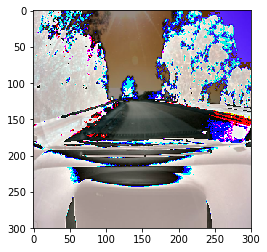

In [48]:
temp_train_batch = train_batches.next()
print('X shape: ', temp_train_batch[0].shape)
print('Y shape: ', temp_train_batch[1].shape)

plt.imshow(temp_train_batch[0][0].astype('uint8'))

## Start Modelling

I used an ensemble of 3 pretrained ConvNets: ResNet50, ResNet101 and DenseNet121. Each model I trained on a different train/validation split and averaged their predictions on the test set.

In [49]:
# choose the convnet
base_model = ResNet50(include_top=False, input_shape=img_size + (3,))
#base_model = densenet121_model(img_rows=img_size[0], img_cols=img_size[1], color_type=3, num_classes=2)
#base_model = resnet101_model(img_rows=img_size[0], img_cols=img_size[1], color_type=3, num_classes=2)

/home/asterisk30/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [50]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 150, 150, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

Add new classification head. Can use max or average pooling.

In [51]:
ft_map = base_model.get_layer(index=-2).output

x = Conv2D(128, (3,3), padding='same')(ft_map)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)
x = GlobalAveragePooling2D()(x)

model = Model(base_model.input, x)

In [52]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 150, 150, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

First, train only the new classification layer.

In [53]:
# freeze all the base model layers
for layer in base_model.layers:
    layer.trainable = False

Can experiment with different optimising strategies. I found that small learning rates worked the best.

In [54]:
opt = Adam(0.001)#, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

Start training. I repeated the following sequence as necessary: fit -> save_weights -> decrease learning rate -> repeat.

In [55]:
model.fit_generator(train_batches, 
                    steps_per_epoch=np.ceil(train_batches.samples/batch_size), 
                    epochs=5, verbose=1, 
                    validation_data=valid_batches, 
                    validation_steps=np.ceil(valid_batches.samples/batch_size),
                    )

Epoch 1/5
1/1 [==============================] - 8s 8s/step - loss: 0.8165 - acc: 0.5000
Epoch 2/5
1/1 [==============================] - 3s 3s/step - loss: 0.2013 - acc: 1.0000
Epoch 3/5
1/1 [==============================] - 3s 3s/step - loss: 0.1407 - acc: 1.0000
Epoch 4/5
1/1 [==============================] - 4s 4s/step - loss: 0.1102 - acc: 1.0000
Epoch 5/5
1/1 [==============================] - 3s 3s/step - loss: 0.1020 - acc: 1.0000


In [56]:
model.save_weights('models/rn50_cls.h5')

In [57]:
K.set_value(model.optimizer.lr, 0.00001)

In [58]:
model.fit_generator(train_batches, 
                    steps_per_epoch=np.ceil(train_batches.samples/batch_size), 
                    epochs=5, verbose=1, 
                    validation_data=valid_batches, 
                    validation_steps=np.ceil(valid_batches.samples/batch_size),
                    )

Epoch 1/5
1/1 [==============================] - 3s 3s/step - loss: 0.1100 - acc: 1.0000
Epoch 2/5
1/1 [==============================] - 4s 4s/step - loss: 0.0694 - acc: 1.0000
Epoch 3/5
1/1 [==============================] - 3s 3s/step - loss: 0.1211 - acc: 1.0000
Epoch 4/5
1/1 [==============================] - 3s 3s/step - loss: 0.1269 - acc: 1.0000
Epoch 5/5
1/1 [==============================] - 4s 4s/step - loss: 0.0995 - acc: 1.0000


In [59]:
model.save_weights('models/rn50_cls.h5')

In [60]:
for i,layer in enumerate(model.layers):
    print(i, layer.name)

0 input_2
1 conv1_pad
2 conv1
3 bn_conv1
4 activation_51
5 max_pooling2d_2
6 res2a_branch2a
7 bn2a_branch2a
8 activation_52
9 res2a_branch2b
10 bn2a_branch2b
11 activation_53
12 res2a_branch2c
13 res2a_branch1
14 bn2a_branch2c
15 bn2a_branch1
16 add_17
17 activation_54
18 res2b_branch2a
19 bn2b_branch2a
20 activation_55
21 res2b_branch2b
22 bn2b_branch2b
23 activation_56
24 res2b_branch2c
25 bn2b_branch2c
26 add_18
27 activation_57
28 res2c_branch2a
29 bn2c_branch2a
30 activation_58
31 res2c_branch2b
32 bn2c_branch2b
33 activation_59
34 res2c_branch2c
35 bn2c_branch2c
36 add_19
37 activation_60
38 res3a_branch2a
39 bn3a_branch2a
40 activation_61
41 res3a_branch2b
42 bn3a_branch2b
43 activation_62
44 res3a_branch2c
45 res3a_branch1
46 bn3a_branch2c
47 bn3a_branch1
48 add_20
49 activation_63
50 res3b_branch2a
51 bn3b_branch2a
52 activation_64
53 res3b_branch2b
54 bn3b_branch2b
55 activation_65
56 res3b_branch2c
57 bn3b_branch2c
58 add_21
59 activation_66
60 res3c_branch2a
61 bn3c_branch2

Fine-tune deeper layers - either conv5 block or conv5 + conv4

In [61]:
for layer in model.layers[:141]:
    layer.trainable = False
    
for layer in model.layers[141:]:
    layer.trainable = True

In [62]:
opt = Adam(0.0001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [63]:
model.fit_generator(train_batches, 
                    steps_per_epoch=np.ceil(train_batches.samples/batch_size), 
                    epochs=5, verbose=1, 
                    validation_data=valid_batches, 
                    validation_steps=np.ceil(valid_batches.samples/batch_size),
                    )

Epoch 1/5
1/1 [==============================] - 49s 49s/step - loss: 0.0651 - acc: 1.0000
Epoch 2/5
1/1 [==============================] - 12s 12s/step - loss: 0.0756 - acc: 1.0000
Epoch 3/5
1/1 [==============================] - 5s 5s/step - loss: 0.0397 - acc: 1.0000
Epoch 4/5
1/1 [==============================] - 5s 5s/step - loss: 0.0277 - acc: 1.0000
Epoch 5/5
1/1 [==============================] - 4s 4s/step - loss: 0.0255 - acc: 1.0000


In [64]:
model.save_weights('models/rn50_block5.h5')

In [65]:
K.set_value(model.optimizer.lr, 0.00001)

In [66]:
model.fit_generator(train_batches, 
                    steps_per_epoch=np.ceil(train_batches.samples/batch_size), 
                    epochs=3, verbose=1, 
                    validation_data=valid_batches, 
                    validation_steps=np.ceil(valid_batches.samples/batch_size),
                    )

Epoch 1/3
1/1 [==============================] - 4s 4s/step - loss: 0.0209 - acc: 1.0000
Epoch 2/3
1/1 [==============================] - 4s 4s/step - loss: 0.0309 - acc: 1.0000
Epoch 3/3
1/1 [==============================] - 5s 5s/step - loss: 0.0236 - acc: 1.0000


In [67]:
model.save_weights('models/rn50_block5.h5')

In [68]:
K.set_value(model.optimizer.lr, 0.000001)

In [69]:
model.fit_generator(train_batches, 
                    steps_per_epoch=np.ceil(train_batches.samples/batch_size), 
                    epochs=2, verbose=1, 
                    validation_data=valid_batches, 
                    validation_steps=np.ceil(valid_batches.samples/batch_size),
                    )

Epoch 1/2
1/1 [==============================] - 4s 4s/step - loss: 0.0290 - acc: 1.0000
Epoch 2/2
1/1 [==============================] - 4s 4s/step - loss: 0.0313 - acc: 1.0000


## Evaluate on hold-out sets

### Validation

Here we test the model on the validation set, but it can also be applied to the test set.

In [33]:
# load data in memory
valid_batches.reset()
x_valid = np.vstack([valid_batches.next()[0] for x in range(int(np.ceil(valid_batches.samples/batch_size)))])

ValueError: need at least one array to concatenate

In [ ]:
valid_batches.reset()
y_valid = np.concatenate([valid_batches.next()[1] for x in range(int(np.ceil(valid_batches.samples/batch_size)))])

Little bit of TTA, predict on both horisontal orientations.

In [ ]:
p_valid = np.zeros_like(y_valid)
for flip in [False, True]:
    temp_x = x_valid
    if flip:
        temp_x = img.flip_axis(temp_x, axis=2)
    p_valid += 0.5 * np.reshape(model.predict(temp_x, verbose=1), y_valid.shape)

Accuracy

In [ ]:
np.mean((p_valid > 0.5) == y_valid)

### Test

In [ ]:
# load data in memory
test_batches.reset()
x_test = np.vstack([test_batches.next()[0] for x in range(int(np.ceil(test_batches.samples/batch_size)))])

In [ ]:
test_batches.reset()
y_test = np.concatenate([test_batches.next()[1] for x in range(int(np.ceil(test_batches.samples/batch_size)))])

Little bit of TTA, predict on both horisontal orientations.

In [ ]:
p_test = np.zeros_like(y_test)
for flip in [False, True]:
    temp_x = x_test
    if flip:
        temp_x = img.flip_axis(temp_x, axis=2)
    p_test += 0.5 * np.reshape(model.predict(temp_x, verbose=1), y_test.shape)

Accuracy

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
np.mean((p_test > 0.5) == y_test)

## Pothole localisation

In [ ]:
cam_extract = Model(base_model.input, model.get_layer(index=-3).output)

In [ ]:
cam_valid = cam_extract.predict(x_valid, verbose=1)

In [ ]:
valid_ind = np.random.randint(low=0,high=500)
valid_file = valid_batches.filenames[valid_ind]
print(valid_file)

In [ ]:
valid_cam = cam_extract.predict(np.expand_dims(x_valid[valid_ind], 0))
np.max(valid_cam)

In [ ]:
overlay = img.array_to_img(valid_cam[0]).resize((800,600), Image.BILINEAR).convert('RGB')
bg = img.load_img('data/valid/' + valid_file)#.resize((300,300))

In [ ]:
Image.blend(alpha=0.5, im1=bg, im2=overlay)

In [ ]:
test_ind = np.random.randint(high=1500,low=0)
test_file = test_batches.filenames[test_ind]
print(test_file)

In [ ]:
test_cam = cam_extract.predict(np.expand_dims(x_test[test_ind], 0))
np.max(test_cam)

In [ ]:
overlay = img.array_to_img(test_cam[0]).resize((800,600), Image.BILINEAR).convert('RGB')
bg = img.load_img('data/test/' + test_file)#.resize((300,300))

In [ ]:
Image.blend(alpha=0.5, im1=bg, im2=overlay)